# Лабораторна робота №1. Побудова еліпсів Петуніна

In [1]:
import copy
import operator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
%matplotlib inline
np.random.seed(0)

## 1. Набір точок

### 1.1. Випадкова генерація точок

Функція:

In [2]:
def get_random_points(limits, n_points):
    x_min, x_max, y_min, y_max = limits
    xs = np.random.uniform(x_min, x_max, n_points)
    ys = np.random.uniform(y_min, y_max, n_points)
    return xs + 1j * ys

Використання:

In [3]:
limits = (-10, 10, -5, 5)
n_points = 1 << 8
points = get_random_points(limits, n_points)

### 1.2. Запис точок у файл

Функція:

In [4]:
def write_points(points, filename):
    with open(filename, 'w') as file:
        file.write(str(points.shape[0]) + '\n')
        for point in points:
            file.write(f"{point.real} {point.imag}\n")

Використання:

In [5]:
write_points(points, f'random_{n_points}.txt')

### 1.3. Зчитування точок з файлу

Функція:

In [6]:
def read_points(filename):
    """ input format:
    n_points
    x_1 y_1
    x_2 y_2
    ... ...
    x_n y_n
    """
    with open(filename, 'r') as file:
        n_points = int(file.readline())
        points = []
        for i in range(n_points):
            xi, yi = map(float, file.readline().split())
            points.append(xi + 1j * yi)
        return np.array(points)

Використання:

In [7]:
assert(np.allclose(points, read_points(f'random_{n_points}.txt')))

## 2. Пошук найвіддаленішої пари точок

### 2.1. Наївний квадратичний алгоритм

Функція:

In [8]:
def find_furthest_points(points):
    max_distance = 0
    indices = 0, 0
    for first_index, first_point in enumerate(points):
        for second_index, second_point in enumerate(points[:first_index]):
            distance = np.abs(first_point - second_point)
            if max_distance < distance:
                max_distance = distance
                indices = first_index, second_index
    return sorted(indices, key=lambda index: points[index].real)

Використання:

In [9]:
indices = find_furthest_points(points)

## 3. Поворот точок

### 3.1. Пошук кута повороту

Функція:

In [10]:
def get_rotation_angle(points, indices):
    return np.angle(points[indices[1]] - points[indices[0]])

Використання:

In [11]:
rotation_angle = get_rotation_angle(points, indices)

### 3.2. Власне поворот

Функція:

In [12]:
def rotate_points(points, rotation_center, rotation_angle):
    return (points - rotation_center) * np.exp(1j * rotation_angle) + rotation_center

Використання:

In [13]:
rotation_center = np.mean(points[indices])
rotated_points = rotate_points(points, rotation_center, -rotation_angle)

In [14]:
assert(np.allclose(points,
    rotate_points(rotated_points, rotation_center, rotation_angle)))

### 4. Пошук перпендикулярів

### 4.1. Пошук екстремальних точок

Функція:

In [15]:
def get_vertical_extremes(points):
    return [np.argmin(points.imag), np.argmax(points.imag)]

Використання:

In [16]:
vertical_indices = get_vertical_extremes(rotated_points)

### 4.2. Подубова самих перпендикулярів

Функція:

In [17]:
def get_vertical_perpendiculars(points, indices, vertical_indices):
    vertical_shift =  np.mean(points[indices]).imag
    first_segment = np.array([points[vertical_indices[0]], points[vertical_indices[0]].real + 1j * vertical_shift])
    second_segment = np.array([points[vertical_indices[1]], points[vertical_indices[1]].real + 1j * vertical_shift])
    return np.array([first_segment, second_segment])

Використання:

In [18]:
vertical_perpendiculars = get_vertical_perpendiculars(rotated_points, indices, vertical_indices)

## 5. Стиск точок

### 5.1. Пошук коефіцієнту стиску

Функція

In [19]:
def get_compression_ratio(rotated_points, indices, vertical_indices):
    x_extent = np.abs(rotated_points[indices[1]].real -
                      rotated_points[indices[0]].real)
    y_extent = np.abs(rotated_points[vertical_indices[1]].imag -
                      rotated_points[vertical_indices[0]].imag)
    return y_extent / x_extent

Використання

In [20]:
compression_ratio = get_compression_ratio(rotated_points, indices, vertical_indices)

### 5.2. Власне стиск

Функція:

In [21]:
def compress_points(rotated_points, indices, vertical_perpendiculars, compression_ratio):
    compressed_points = rotated_points.copy()
    compressed_points.real = compressed_points.real * compression_ratio
    compressed_segments = vertical_perpendiculars.copy()
    compressed_segments.real = compressed_segments.real * compression_ratio
    return compressed_points, compressed_segments

Застосування:

In [22]:
compressed_points, compressed_segments = \
    compress_points(rotated_points, indices, vertical_perpendiculars, compression_ratio)

In [23]:
assert(np.allclose(rotated_points,
    compress_points(compressed_points, indices, vertical_perpendiculars, 1 / compression_ratio)[0]))

## 6. Концентричні кола

### 6.1. Пошук центру кіл

Функція

In [24]:
def get_center(points, indices, vertical_indices):
    return np.mean(points[indices]).real + np.mean(points[vertical_indices].imag)

Використання:

In [25]:
center = get_center(compressed_points, indices, vertical_indices)

### 6.2. Рахуємо, скільки точок потрапило у кожне коло

Функція

In [26]:
def get_counts(compressed_points, center):
    sorted_indices = np.array([
        i for i, point in sorted(list(enumerate(compressed_points)),
                                 key=lambda i_point: np.abs(i_point[1] - center))
    ])
    counts = np.arange(compressed_points.shape[0])
    counts[sorted_indices] = counts.copy()
    return counts 

Використання:

In [27]:
counts = get_counts(compressed_points, center)

### 6.3. Клас для моделювання кола

Клас:

In [28]:
class MyCircle:
    def __init__(self, canter, radius, count):
        self.center = canter
        self.radius = radius
        self.count = count

    def __repr__(self):
        return f"MyCircle(center={self.center:.3f}, radius={self.radius:.3f}, count={self.count})"

Конструювання:

In [29]:
circles = [MyCircle(center, np.abs(center - point), counts[i])
           for i, point in enumerate(compressed_points)]
circles.sort(key=operator.attrgetter('count'))

Вивід

In [30]:
print(*circles[:5], sep='\n')

MyCircle(center=0.144, radius=0.236, count=0)
MyCircle(center=0.144, radius=0.894, count=1)
MyCircle(center=0.144, radius=1.028, count=2)
MyCircle(center=0.144, radius=1.085, count=3)
MyCircle(center=0.144, radius=1.100, count=4)


## 7. Еліпси Петуніна

### 7.1. Клас для моделювання еліпса

Клас

In [31]:
class MyEllipse:
    def __init__(self, center, width, height, angle=0, count=0):
        self.center = center
        self.width = width
        self.height = height
        self.angle = angle
        self.count = count

    def __str__(self):
        return f"MyEllipse(center={self.center:.3f}, width={self.width:.3f}, " \
            f"height={self.height:.3f}, angle={self.angle:.3f}, count={self.count})"

Конструювання

In [32]:
rotated_ellipses = []
rotated_center = center / compression_ratio
for circle in circles:
    rotated_ellipses.append(MyEllipse(rotated_center, 2 * circle.radius / compression_ratio,
                              2 * circle.radius, angle=0, count=circle.count))

Вивід

In [33]:
print(*rotated_ellipses[:5], sep="\n")

MyEllipse(center=0.182, width=0.593, height=0.471, angle=0.000, count=0)
MyEllipse(center=0.182, width=2.250, height=1.787, angle=0.000, count=1)
MyEllipse(center=0.182, width=2.587, height=2.055, angle=0.000, count=2)
MyEllipse(center=0.182, width=2.731, height=2.170, angle=0.000, count=3)
MyEllipse(center=0.182, width=2.768, height=2.200, angle=0.000, count=4)


### 8. Початкові еліпси

Поворот еліпсів

In [34]:
center = rotate_points(rotated_center, rotation_center, rotation_angle)
ellipses = copy.deepcopy(rotated_ellipses)
for ellipse in ellipses:
    ellipse.angle = np.degrees(rotation_angle)
    ellipse.center = center

Вивід

In [35]:
print(*ellipses[:5], sep="\n")

MyEllipse(center=0.202-0.265j, width=0.593, height=0.471, angle=-26.890, count=0)
MyEllipse(center=0.202-0.265j, width=2.250, height=1.787, angle=-26.890, count=1)
MyEllipse(center=0.202-0.265j, width=2.587, height=2.055, angle=-26.890, count=2)
MyEllipse(center=0.202-0.265j, width=2.731, height=2.170, angle=-26.890, count=3)
MyEllipse(center=0.202-0.265j, width=2.768, height=2.200, angle=-26.890, count=4)


Поворот відрізків

In [36]:
perpendiculars = rotate_points(vertical_perpendiculars, rotation_center, rotation_angle)

## 9. Рисунки

### 9.1. Просто точки

Функція:

In [37]:
def first_pic(points, limits, size=7, title=''):
    x_min, x_max, y_min, y_max = limits
    figsize = np.array((x_max - x_min, y_max - y_min))
    figsize = figsize * size / np.max(figsize)
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.axis("equal")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")

    ax.scatter(points.real, points.imag, color='blue')

    return fig

Використання:

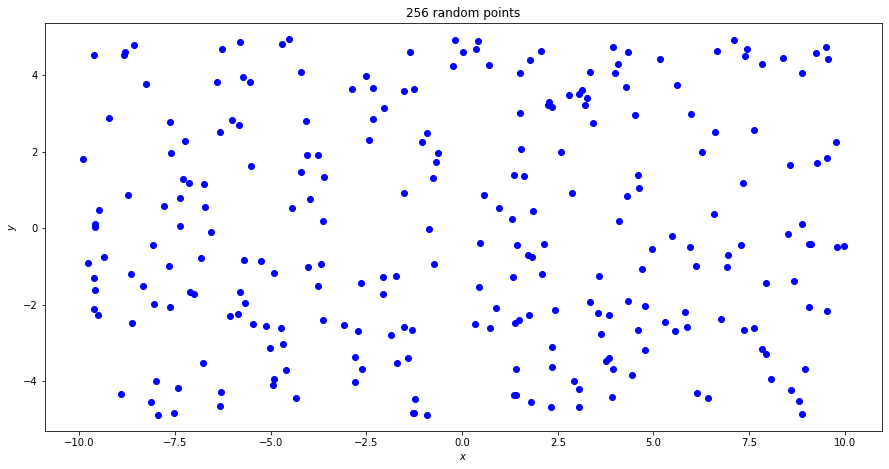

In [38]:
first_pic(points, limits, size=15, title=f'{n_points} random points');

### 9.2. Найвіддаленіші точки

Функція:

In [39]:
def second_pic(points, limits, indices, size=7, title=''):
    fig = first_pic(points, limits, size, title)
    fig.axes[0].plot(points[indices].real, points[indices].imag, color='red')
    return fig

Використання:

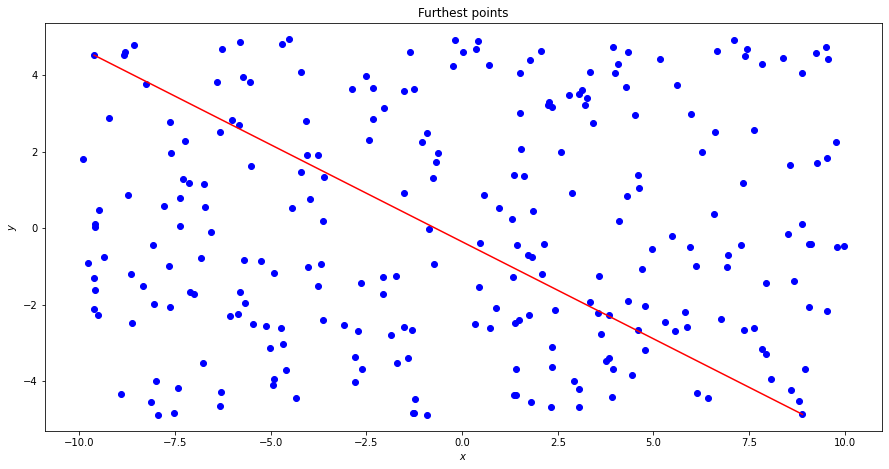

In [40]:
second_pic(points, limits, indices, size=15, title='Furthest points');

### 9.3. Повернуті точки

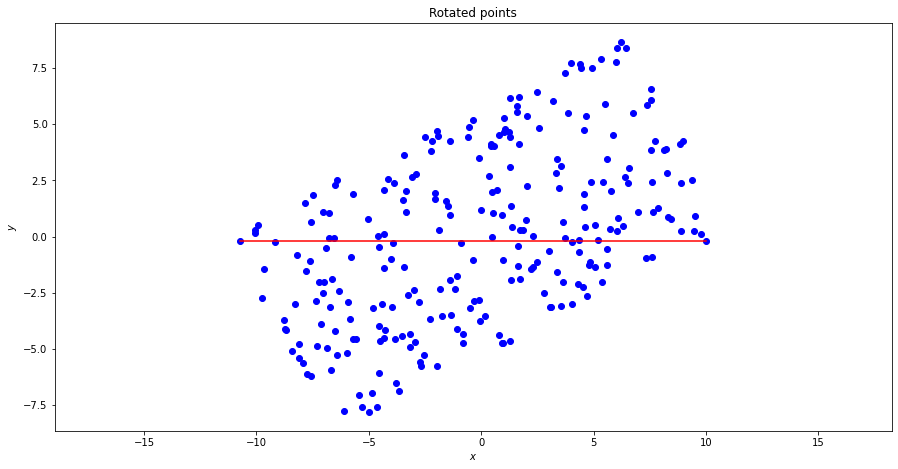

In [41]:
second_pic(rotated_points, limits, indices, size=15, title='Rotated points');

### 9.4. Пошук перпендикулярів

Функція

In [42]:
def third_pic(rotated_points, indices, vertical_perpendiculars, size=7, title=''):
    limits = (np.max(rotated_points.real), np.min(rotated_points.real),
              np.max(rotated_points.imag), np.min(rotated_points.imag))
    fig = second_pic(rotated_points, limits, indices, size, title)
    ax = fig.axes[0]
    ax.plot(vertical_perpendiculars[0].real,
            vertical_perpendiculars[0].imag, color='red')
    ax.plot(vertical_perpendiculars[1].real, 
            vertical_perpendiculars[1].imag, color='red')
    return fig

Використання

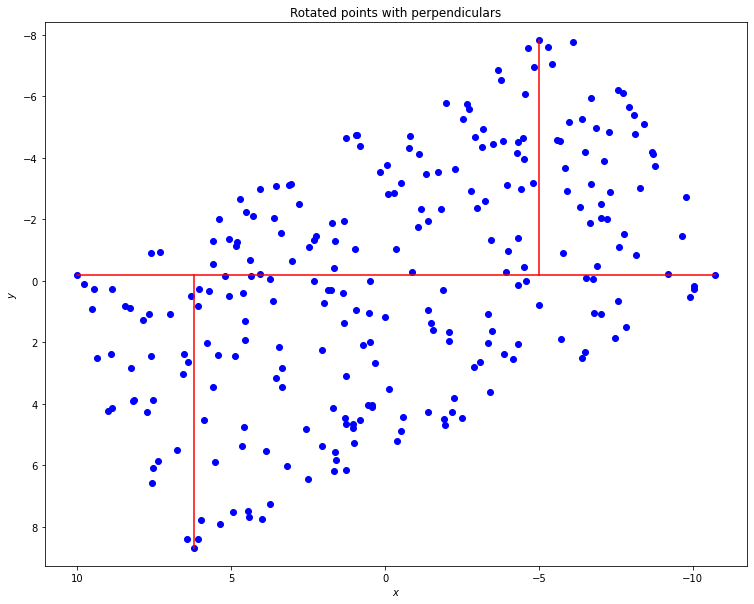

In [43]:
third_pic(rotated_points, indices, vertical_perpendiculars, size=10,
          title='Rotated points with perpendiculars');

### 9.5. Стиск точок

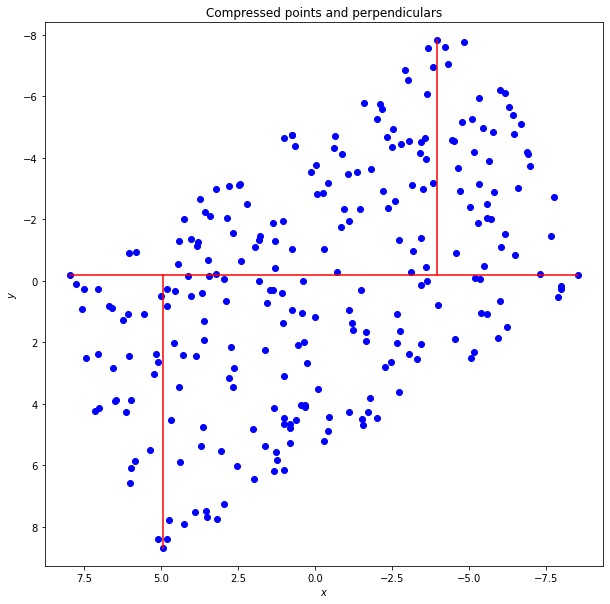

In [44]:
third_pic(compressed_points, indices, compressed_segments, size=10,
          title='Compressed points and perpendiculars');

### 9.6. Концентричні кола

Функція

In [45]:
def fourth_pic(compressed_points, indices, vertical_indices, compressed_segments,
               rotated_center, circles, size=7, title='', step=1):
    fig = third_pic(compressed_points, indices, compressed_segments,
                    size=size, title=title)
    ax = fig.axes[0]
    ax.scatter(rotated_center.real, rotated_center.imag, color='red')
    for circle in circles[-1::-step]:
        circle_patch = ptc.Circle((circle.center.real, circle.center.imag),
                                  circle.radius, fill=False, color='blue')
        ax.add_patch(circle_patch)
    return fig

Використання

In [46]:
step = compressed_points.shape[0]
step //= np.int32(np.log2(compressed_points.shape[0]))

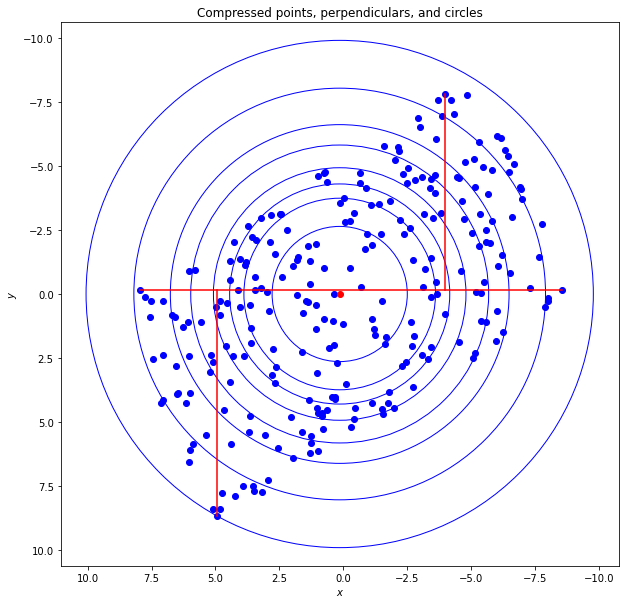

In [47]:
fourth_pic(compressed_points, indices, vertical_indices, compressed_segments,
           rotated_center * compression_ratio, circles,
           size=10, title='Compressed points, perpendiculars, and circles', step=step);

### 9.7. Повернуті еліпси

In [48]:
def fifth_pic(rotated_points, indices, vertical_indices, vertical_perpendiculars, rotated_center,
              rotated_ellipses, size=7, title='', step=1):
    fig = third_pic(rotated_points, indices, vertical_perpendiculars,
                    size=size, title=title)
    ax = fig.axes[0]
    ax.scatter(rotated_center.real, rotated_center.imag, color='red')
    for ellipse in rotated_ellipses[-1::-step]:
        ax.add_patch(ptc.Ellipse((ellipse.center.real, ellipse.center.imag),
                                 ellipse.width, ellipse.height,
                                 angle=ellipse.angle, fill=False, color='blue'))
    return fig

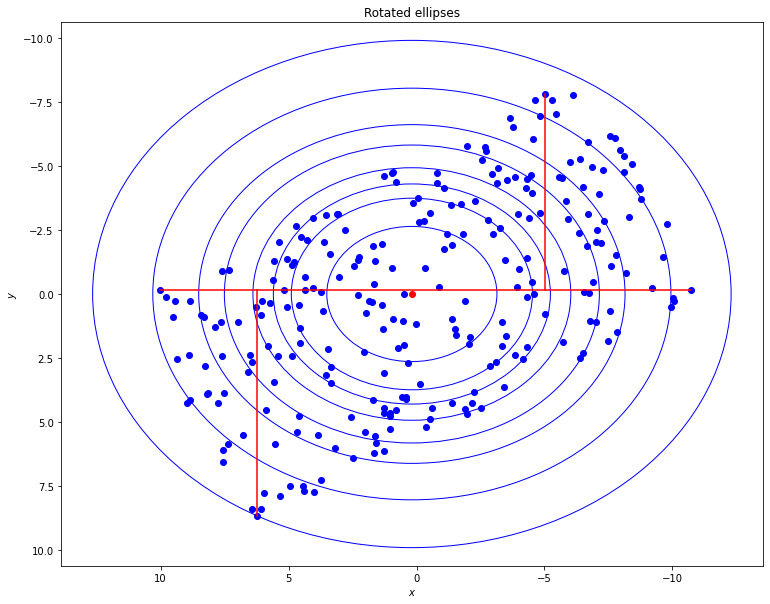

In [49]:
fifth_pic(rotated_points, indices, vertical_indices, vertical_perpendiculars, rotated_center,
          rotated_ellipses, size=10, title='Rotated ellipses', step=step);

### 9.8. Початкові еліпси із допоміжними відрізками

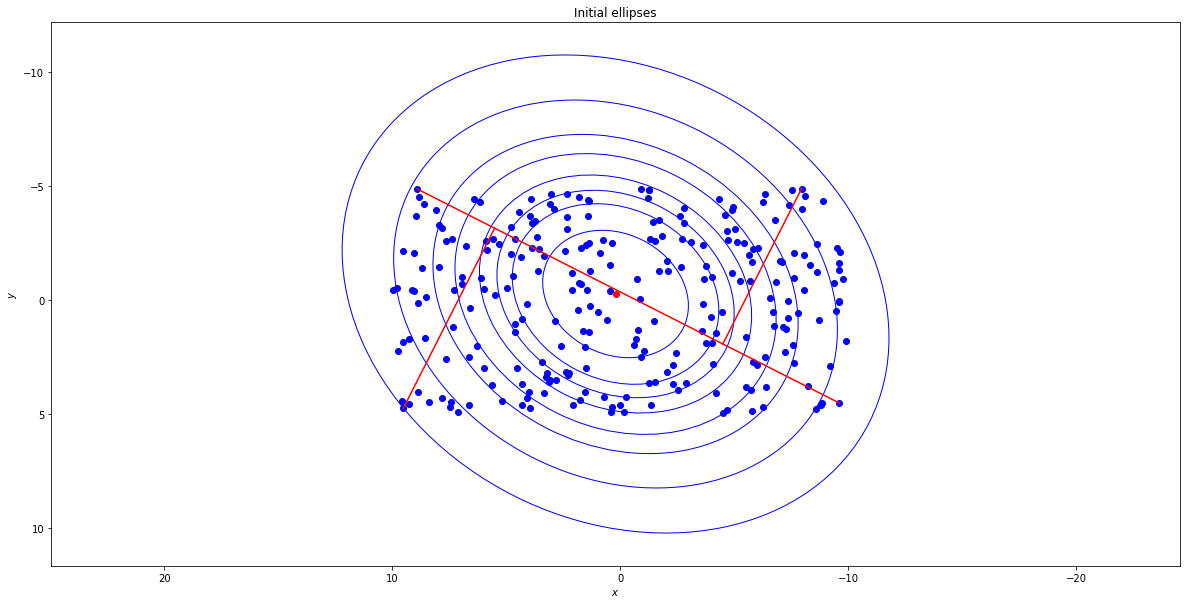

In [50]:
fifth_pic(points, indices, vertical_indices, perpendiculars, center, ellipses,
          size=10, title='Initial ellipses', step=step);

### 9.9. Початкові еліпси без допоміжних відрізків

Функція

In [51]:
def end_pic(points, indices, vertical_indices, ellipses, center, size=7, title='', step=1):
    limits = (np.max(points.real), np.min(points.real),
              np.max(points.imag), np.min(points.imag))
    fig= first_pic(points, limits, size, title)
    ax = fig.axes[0]
    ax.scatter(center.real, center.imag, color='red')
    for ellipse in ellipses[-1::-step]:
        ax.add_patch(ptc.Ellipse((ellipse.center.real, ellipse.center.imag),
                                 ellipse.width, ellipse.height,
                                 angle=ellipse.angle, fill=False, color='blue'))
    return fig

Використання

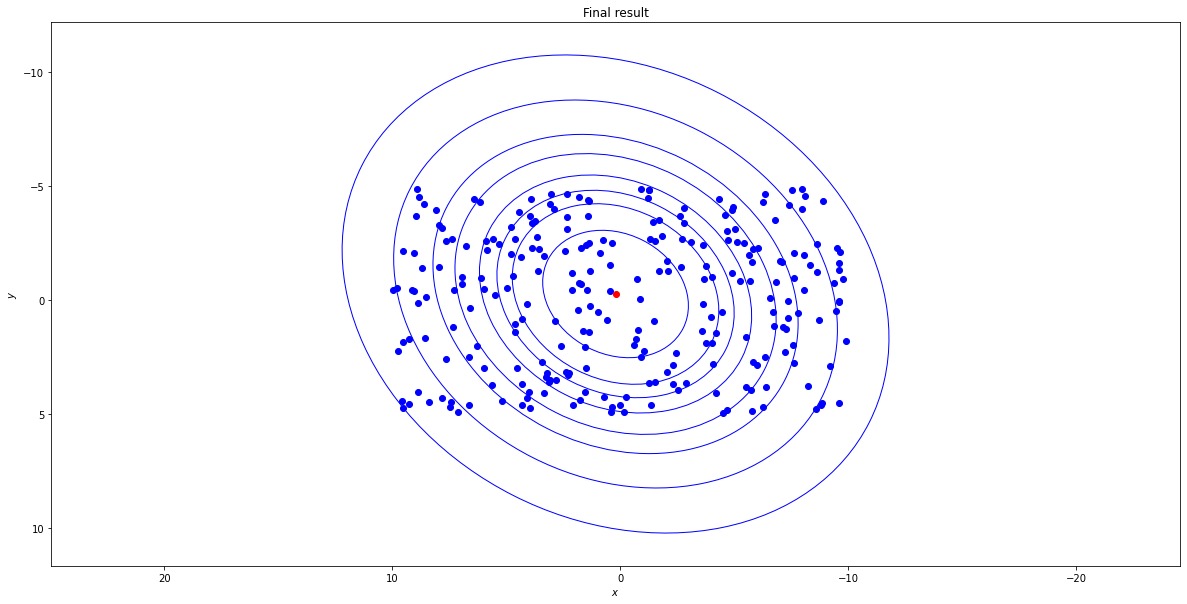

In [52]:
end_pic(points, indices, vertical_indices, ellipses, center,
        size=10, title='Final result', step=step);